# **Anime Classificatio - Pre Modeling**

From the **EDA** visualisation:

- At Section 7: Top 100 Most Popular Anime (Regardless of Rank), we found otu that we cannot judge how successful the anime is just based on factor like rank only or popularity only. As we can see from that graph, there were anime that were very popular but has very low ranking meaning low score also, for example the Sword Art Anime II.

In conclusion, to determine if the anime is successful:
- we will be looking at the popularity, rank and mean score of the anime

## Import Required Libraries

In [146]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter
#sklearn libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score #for accuracy score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder #2nd encoder
from sklearn.ensemble import ExtraTreesClassifier #feature selection
from sklearn.model_selection import cross_val_score #model selection (k-fold)
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV #hyperparameter tuning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.dummy import DummyClassifier #stupid baseline
from sklearn.ensemble import RandomForestClassifier #features importance
from sklearn.model_selection import RepeatedStratifiedKFold


#classification model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC #support vector machine
from sklearn.linear_model import LogisticRegression #for stupid baseline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

#set read full columns of df
pd.set_option('display.max_columns', None)

## Import Dataset

In [147]:
anime = pd.read_csv("data/anime_clean.csv")
anime.head(n=3)

,title_x,type,source,episodes,status,duration,score,scored_by,rank,popularity,members,favorites,synopsis,season,studios,start_date,end_date,final_genres,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,completion_rate,drop_rate,retention_rate
0,Cowboy Bebop,TV,Original,26.0,Finished Airing,24 min per ep,8.75,961043.0,46.0,43,1858633,82129,"Crime is timeless. By the year 2071, humanity ...",spring,Sunrise,1998-04-03,1999-04-24,"Action,Award Winning,Sci-Fi,Adult Cast,Space",172641,1074282,106532,43071,463385,1859911,0.832781,0.033389,0.969158
1,Cowboy Bebop Tengoku no Tobira,Movie,Original,1.0,Finished Airing,1 hr 55 min,8.38,214605.0,191.0,618,376846,1576,"Another day, another bounty—such is the life o...",summer,Bones,2001-09-01,2001-09-01,"Action,Sci-Fi,Adult Cast,Space",7049,279039,2977,1199,86822,377086,0.971290,0.004174,0.995869
2,Trigun,TV,Manga,26.0,Finished Airing,24 min per ep,8.22,372073.0,347.0,252,761057,15954,"Vash the Stampede is the man with a $$60,000,0...",spring,Madhouse,1998-04-01,1998-09-30,"Action,Adventure,Sci-Fi,Adult Cast",46428,446619,33460,18756,216243,761506,0.872638,0.036647,0.965602


In [148]:
len(anime)

12966

In [149]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12966 entries, 0 to 12965
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   title_x                    12966 non-null  object 
 1   type                       12966 non-null  object 
 2   source                     12966 non-null  object 
 3   episodes                   12966 non-null  float64
 4   status                     12966 non-null  object 
 5   duration                   12966 non-null  object 
 6   score                      12966 non-null  float64
 7   scored_by                  12966 non-null  float64
 8   rank                       12966 non-null  float64
 9   popularity                 12966 non-null  int64  
 10  members                    12966 non-null  int64  
 11  favorites                  12966 non-null  int64  
 12  synopsis                   12966 non-null  object 
 13  season                     12966 non-null  obj

## 1. Create The Target Variable Column

**Target Variable Column Value**:
- Successful (1)
- Unsuccessful (0)

**Factors determining successful (1) anime:**
- Top 500 in Ranking
- Top 500 in Popularity
- Score >= 8.0
- else the others are unsucessful (0) anime


In [150]:
# Function to create the target variable
def create_target_variable(df):
    # Define conditions for a successful anime
    conditions = [
        (df['rank'] <= 600) | (df['popularity'] <= 600) | (df['score'] >= 8.5)
    ]
    
    # Define the label for the conditions
    labels = [1]  # 1 corresponds to successful
    
    # Create a new column and use np.select to assign values to it using our lists as arguments
    df['successful'] = np.select(conditions, labels, default=0)
    
    return df

# Apply the function to the sample DataFrame
anime = create_target_variable(anime)

# Display the modified DataFrame with the new 'successful' column
anime


,title_x,type,source,episodes,status,duration,score,scored_by,rank,popularity,members,favorites,synopsis,season,studios,start_date,end_date,final_genres,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,completion_rate,drop_rate,retention_rate,successful
0,Cowboy Bebop,TV,Original,26.0,Finished Airing,24 min per ep,8.75,961043.0,46.0,43,1858633,82129,"Crime is timeless. By the year 2071, humanity ...",spring,Sunrise,1998-04-03,1999-04-24,"Action,Award Winning,Sci-Fi,Adult Cast,Space",172641,1074282,106532,43071,463385,1859911,0.832781,0.033389,0.969158,1
1,Cowboy Bebop Tengoku no Tobira,Movie,Original,1.0,Finished Airing,1 hr 55 min,8.38,214605.0,191.0,618,376846,1576,"Another day, another bounty—such is the life o...",summer,Bones,2001-09-01,2001-09-01,"Action,Sci-Fi,Adult Cast,Space",7049,279039,2977,1199,86822,377086,0.971290,0.004174,0.995869,1
2,Trigun,TV,Manga,26.0,Finished Airing,24 min per ep,8.22,372073.0,347.0,252,761057,15954,"Vash the Stampede is the man with a $$60,000,0...",spring,Madhouse,1998-04-01,1998-09-30,"Action,Adventure,Sci-Fi,Adult Cast",46428,446619,33460,18756,216243,761506,0.872638,0.036647,0.965602,1
3,Witch Hunter Robin,TV,Original,26.0,Finished Airing,25 min per ep,7.24,43768.0,3036.0,1849,116366,644,Robin Sena is a powerful craft user drafted in...,summer,Sunrise,2002-07-03,2002-12-25,"Action,Drama,Mystery,Supernatural,Detective",5718,52322,5956,6229,46203,116428,0.814109,0.096921,0.911299,0
4,Bouken Ou Beet,TV,Manga,52.0,Finished Airing,23 min per ep,6.93,6516.0,4538.0,5349,15413,15,It is the dark century and the people are suff...,summer,Toei Animation,2004-09-30,2005-09-29,"Action,Adventure,Fantasy",825,8234,839,1242,4276,15416,0.799340,0.120571,0.888510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12961,Spy x Family Movie Code White Manner Movie,Movie,Manga,1.0,Finished Airing,59 sec,6.44,244.0,7183.0,11701,1690,5,Wit Studio and Cloverworks released a new shor...,summer,"Wit Studio,CloverWorks",2023-07-28,2023-07-28,"Comedy,Educational",104,383,49,40,1157,1733,0.726755,0.075901,0.930556,0
12962,Ore dake Level Up na Ken How to Get Stronger,TV Special,Web manga,1.0,Finished Airing,23 min,5.72,6177.0,10768.0,5807,12523,65,Recap of the first seven episodes of Ore dake ...,winter,A-1 Pictures,2024-02-25,2024-02-25,"Action,Adventure,Fantasy",929,9534,75,285,1969,12792,0.887049,0.026517,0.973667,0
12963,Bucchigiri! Yomigaeru! Konya wa Bucchii Back t...,TV Special,Original,1.0,Finished Airing,23 min,5.61,964.0,11207.0,10735,2341,5,Recap of the first six episodes of Bucchigiri?!.,winter,MAPPA,2024-02-24,2024-02-24,"Comedy,Fantasy,Delinquents,School",209,1474,26,83,596,2388,0.834655,0.046999,0.953683,0
12964,Ojamajo Carnival!!,ONA,Original,1.0,Finished Airing,1 min,7.77,559.0,1047.0,12455,1312,5,Ojamajo Carnival!! commemorates the 25th anniv...,winter,Toei Animation,2024-03-23,2024-03-23,Mahou Shoujo,65,894,12,19,387,1377,0.914110,0.019427,0.980808,0


## 2. EDA

In [151]:
anime['successful'].value_counts()

successful
0    12037
1      929
Name: count, dtype: int64

### Distribution of Target Variable

It imbalance

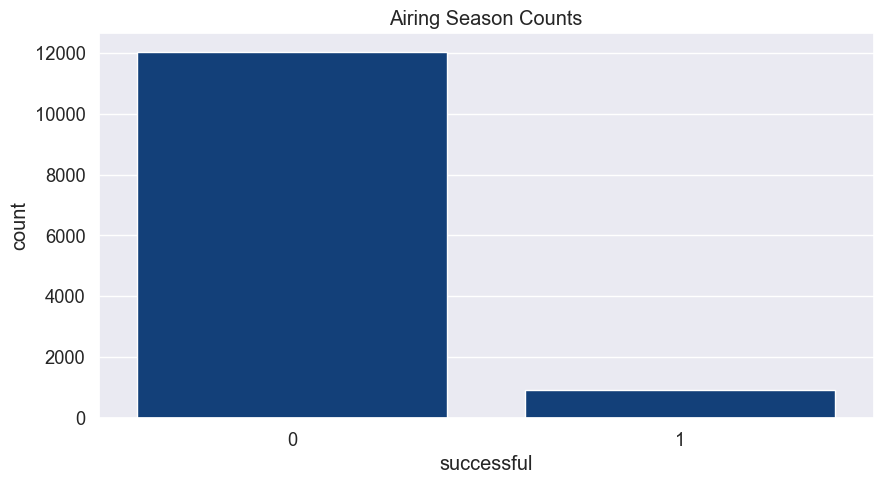

In [152]:
# Set the figure size
plt.figure(figsize=(10, 5))

#plot the graph
sb.barplot(data=anime['successful'].value_counts(), color='#023e8a').set(title="Airing Season Counts")
plt.show()

## Correlation Heat Map (Numerical Features)

From the below findings we will be keeping: favorites, members, statistics_num_list_users, as they have a higher correlation with the target variable as compared to the other features

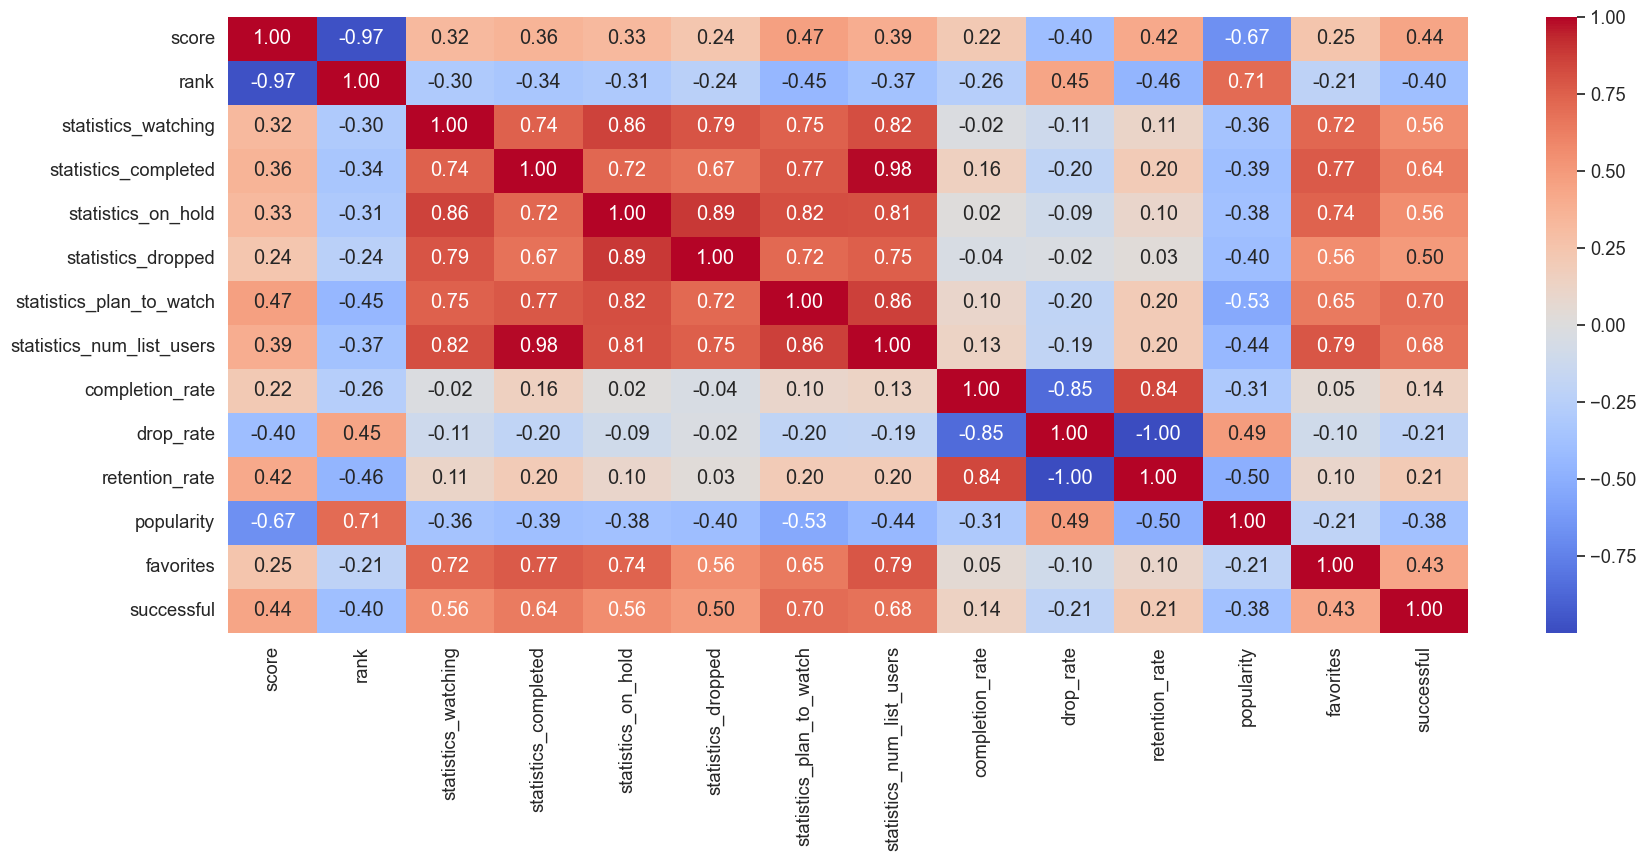

In [153]:
# Select the desired columns for the correlation matrix
selected_columns = ['score','rank','statistics_watching','statistics_completed',
                    'statistics_on_hold','statistics_dropped','statistics_plan_to_watch',
                    'statistics_num_list_users','completion_rate','drop_rate','retention_rate', 'popularity', 'favorites', 'successful']


# Compute the correlation matrix
correlation_matrix = anime[selected_columns].corr()

# Set the size of the plot
plt.figure(figsize=(20, 8))

# Generate the heatmap
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()

We can see from the heat map there is a few features which are correlated with the successful target variable which is statistics_watching, statistics_completed, statistics_on_hold, statistics_dropped, statistics_plan_to_watch, statistics_num_list_users which are above 0.5 correlation, but since most of them are correlated with each other so I will jus be keep the statistics_plan_to_watch which has the highest correaltion out of all of them

In [154]:
#numerical cols that we are keeping
num_cols = ['statistics_plan_to_watch']

## 3. Feature Engineering

### 3.1 One Hot Encoding - Unravel Categorical Cols


#### Step:
- Unravel all the categorical column into multiple columns, converting this categorical columns into one hot encoding

### Why is it important?:
- It ensure that machine learning does not assume that high numbers are more important
- **Feature importance:** Each category becomes its own feature, allowing algorithms to determine the importance or influence of each category on the prediction.
- **Machine Learning Model Compatibility:** Most machine learning algorithms require numerical input and cannot handle categorical variables directly. Unraveling converts categories into a format that these algorithms can work with.




In [155]:
#copy the dataset
anime_final = anime.copy()

In [156]:
#categorical column
cat_col = ['type', 'source', 'studios', 'final_genres']

In [157]:
# create a function to unravel those columns whhich ahve multiple values
def unravel_column(df, column_name):

    # Initialize an empty set to collect unique categories
    unique_categories = set()

    # loop through each row and split the value by comma
    df[column_name].dropna().apply(lambda x: unique_categories.update(x.split(',')))

    # Initialize a dictionary to hold our new columns
    new_columns = {}

    # Create a new binary column for each unique category
    for category in unique_categories:

        # concatenate the new column name which is column + category name
        new_column_name = f'{column_name}_{category}'

        # Apply a lambda function to set 1 if the category is present in the row, 0 otherwise
        new_columns[new_column_name] = df[column_name].apply(lambda x: int(category in str(x).split(',')))

    # Concatenate the new columns to the original DataFrame all at once
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
    
    return df



# Unravel the 'genres' column
for cat in cat_col:
    anime_final = unravel_column(anime_final, cat)


In [158]:
anime_final.drop(['final_genres_Award Winning', 'studios_no_studios'] ,axis=1 ,inplace=True)

In [159]:
anime_final

,title_x,type,source,episodes,status,duration,score,scored_by,rank,popularity,members,favorites,synopsis,season,studios,start_date,end_date,final_genres,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,completion_rate,drop_rate,retention_rate,successful,type_ONA,type_OVA,type_TV,type_TV Special,type_Special,type_Movie,source_Unknown,source_Light novel,source_Original,source_Mixed media,source_Card game,source_Other,source_4-koma manga,source_Picture book,source_Radio,source_Web novel,source_Manga,source_Music,source_Web manga,source_Book,source_Game,source_Visual novel,source_Novel,studios_Production Wave,studios_Production IMS,studios_SJYNEXCUS,studios_Space Neko Company,studios_Phoenix Entertainment,studios_KOO-KI,studios_EMT Squared,studios_Romanov Films,studios_Kokusai Eigasha,studios_AtelierPontdarc,studios_BUG FILMS,studios_Trinet Entertainment,studios_Studio Coa,studios_SAMG Entertainment,studios_Paper Animation,studios_Hayabusa Film,studios_Bebow,studios_Qubic Pictures,studios_animate Film,studios_AIC Spirits,studios_Lerche,studios_Aubec,studios_Wit Studio,studios_APPP,studios_KIZAWA Studio,studios_Cloud Hearts,studios_Telescreen,studios_Studio Massket,studios_Studio Izena,studios_Agent 21,studios_Scooter Films,studios_Synergy Japan,studios_EKACHI EPILKA,studios_DAX Production,studios_Takahashi Studio,studios_Shengying Animation,studios_A-Real,studios_Beat Frog,studios_Ankama Animations,studios_Bakken Record,studios_Hoods Entertainment,studios_Fanworks,studios_Next Media Animation,studios_Animation Do,studios_Zero-G Room,studios_Gyorai Eizo Inc.,studios_TOHO animation STUDIO,studios_Acca effe,studios_Shanghai Animation Film Studio,studios_Studio Kelmadick,studios_Griot Groove,studios_Tokyo Movie Shinsha,studios_Sparky Animation,studios_Creators in Pack,studios_Qingxiang Culture,studios_OB Planning,studios_Liberty Animation Studio,studios_Indivision,studios_Kuri Jikken Manga Koubou,studios_AQUA ARIS,studios_Studio Add,studios_Suna Kouhou,studios_Panmedia,studios_Pollyanna Graphics,studios_High Energy Studio,studios_Satelight,studios_Gravity Well,studios_Big Firebird Culture,studios_UchuPeople,studios_Makaria,studios_Imagin,studios_Idol,studios_DRAWIZ,studios_Children's Playground Entertainment,studios_Marine Entertainment,studios_Lay-duce,studios_Tsuchida Productions,studios_Studio Hakk,studios_Alpha Animation,studios_Studio Lings,studios_NAZ,studios_ARECT,studios_Hero,studios_Oh! Production,studios_Fever Creations,studios_Office Nobu,studios_JM Animation,studios_DMM.futureworks,studios_Shirogumi,studios_Ajia-do,studios_A-Line,studios_Dynamic Planning,studios_Milky Cartoon,studios_KAGAYA Studio,studios_P.I.C.S.,studios_aNCHOR,studios_monofilmo,studios_DC Impression Vision,studios_Ripple Film,studios_Hand to Mouse.,studios_Wolf Smoke Studio,studios_Foch Films,studios_Soft Garage,studios_LMD,studios_Sanctuary,studios_Imagineer,studios_Production +h.,studios_Making Animation,studios_XFLAG Pictures,studios_Studio Gokumi,studios_HuaMei Animation,studios_Fuji TV,studios_Studio Tumble,studios_Sanrio,studios_PP Project,studios_AHA Entertainment,studios_Staple Entertainment,studios_Shaft,studios_Annapuru,studios_Horannabi,studios_Okuruto Noboru,studios_Dai-Ichi Douga,studios_7doc,studios_MMT Technology,studios_Kino Production,studios_B.CMAY PICTURES,studios_AZ Creative,studios_Beijing Enlight Pictures,studios_10Gauge,studios_Decovocal,studios_PINE JAM,studios_Production GoodBook,studios_Silver,studios_Signal.MD,studios_AIC ASTA,studios_CMC Media,studios_Lesprit,studios_Pastel,studios_Craftar Studios,studios_Paper Plane Animation Studio,studios_Dynamo Pictures,studios_G-angle,studios_helo.inc,studios_Studio Bind,studios_Studio Deen,studios_Gear Studio,studios_Wawayu Animation,studios_Gainax,studios_Doga Kobo,studios_Studio Jemi,studios_GARDEN LODGE,studios_Echoes,studios_Filmlink International,studios_ufotable,studios_Circus Production,studios_Image 

### 3.2 Scaling Numerical Column

Data scaling is the process of transforming the values of the features of a dataset till they are within a specific range for example 0 to 1 or -1 to 1. This is to ensure that no single feature dominates the distance calculations in an algorithm, and can help to improve the performance of the algorithm. Since our categorical data are in the range of 0 and 1, we will be scaling the numerical data to that too

In [160]:
from sklearn.preprocessing import MinMaxScaler


# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # This will scale features to the range [0, 1]

# Fit the scaler on your numerical data and then transform it
anime_final[num_cols] = scaler.fit_transform(anime_final[num_cols])


### 3.3 Dropping Not Important Features

Now we will be dropping all the numerical features first, as in the EDA part in the EDA_Visualisation.ipynb notebook, it shows that all our numerical features has little correlation to rank, popularity or score, as it has low negative or positive correaltion or less than 0.5, therefore it show no linear relationship so i will be dropping it. Plus, the numerical features actually has not much relation to whether the aniem will be successful anot

In [161]:
#drop the unnecessary columns
anime_final.drop([
    'title_x', 'episodes', 'status', 'duration', 'scored_by', 'members', 'favorites', 'synopsis', 'start_date',
    'end_date', 'type', 'source', 'score', 'rank', 'popularity', 'season', 'studios', 'final_genres', 'statistics_watching', 
    'statistics_completed', 'statistics_on_hold', 'statistics_dropped', 'statistics_num_list_users', 'completion_rate', 'drop_rate', 'retention_rate', 
] ,axis=1 ,inplace=True)



anime_final.head(n=3)

,statistics_plan_to_watch,successful,type_ONA,type_OVA,type_TV,type_TV Special,type_Special,type_Movie,source_Unknown,source_Light novel,source_Original,source_Mixed media,source_Card game,source_Other,source_4-koma manga,source_Picture book,source_Radio,source_Web novel,source_Manga,source_Music,source_Web manga,source_Book,source_Game,source_Visual novel,source_Novel,studios_Production Wave,studios_Production IMS,studios_SJYNEXCUS,studios_Space Neko Company,studios_Phoenix Entertainment,studios_KOO-KI,studios_EMT Squared,studios_Romanov Films,studios_Kokusai Eigasha,studios_AtelierPontdarc,studios_BUG FILMS,studios_Trinet Entertainment,studios_Studio Coa,studios_SAMG Entertainment,studios_Paper Animation,studios_Hayabusa Film,studios_Bebow,studios_Qubic Pictures,studios_animate Film,studios_AIC Spirits,studios_Lerche,studios_Aubec,studios_Wit Studio,studios_APPP,studios_KIZAWA Studio,studios_Cloud Hearts,studios_Telescreen,studios_Studio Massket,studios_Studio Izena,studios_Agent 21,studios_Scooter Films,studios_Synergy Japan,studios_EKACHI EPILKA,studios_DAX Production,studios_Takahashi Studio,studios_Shengying Animation,studios_A-Real,studios_Beat Frog,studios_Ankama Animations,studios_Bakken Record,studios_Hoods Entertainment,studios_Fanworks,studios_Next Media Animation,studios_Animation Do,studios_Zero-G Room,studios_Gyorai Eizo Inc.,studios_TOHO animation STUDIO,studios_Acca effe,studios_Shanghai Animation Film Studio,studios_Studio Kelmadick,studios_Griot Groove,studios_Tokyo Movie Shinsha,studios_Sparky Animation,studios_Creators in Pack,studios_Qingxiang Culture,studios_OB Planning,studios_Liberty Animation Studio,studios_Indivision,studios_Kuri Jikken Manga Koubou,studios_AQUA ARIS,studios_Studio Add,studios_Suna Kouhou,studios_Panmedia,studios_Pollyanna Graphics,studios_High Energy Studio,studios_Satelight,studios_Gravity Well,studios_Big Firebird Culture,studios_UchuPeople,studios_Makaria,studios_Imagin,studios_Idol,studios_DRAWIZ,studios_Children's Playground Entertainment,studios_Marine Entertainment,studios_Lay-duce,studios_Tsuchida Productions,studios_Studio Hakk,studios_Alpha Animation,studios_Studio Lings,studios_NAZ,studios_ARECT,studios_Hero,studios_Oh! Production,studios_Fever Creations,studios_Office Nobu,studios_JM Animation,studios_DMM.futureworks,studios_Shirogumi,studios_Ajia-do,studios_A-Line,studios_Dynamic Planning,studios_Milky Cartoon,studios_KAGAYA Studio,studios_P.I.C.S.,studios_aNCHOR,studios_monofilmo,studios_DC Impression Vision,studios_Ripple Film,studios_Hand to Mouse.,studios_Wolf Smoke Studio,studios_Foch Films,studios_Soft Garage,studios_LMD,studios_Sanctuary,studios_Imagineer,studios_Production +h.,studios_Making Animation,studios_XFLAG Pictures,studios_Studio Gokumi,studios_HuaMei Animation,studios_Fuji TV,studios_Studio Tumble,studios_Sanrio,studios_PP Project,studios_AHA Entertainment,studios_Staple Entertainment,studios_Shaft,studios_Annapuru,studios_Horannabi,studios_Okuruto Noboru,studios_Dai-Ichi Douga,studios_7doc,studios_MMT Technology,studios_Kino Production,studios_B.CMAY PICTURES,studios_AZ Creative,studios_Beijing Enlight Pictures,studios_10Gauge,studios_Decovocal,studios_PINE JAM,studios_Production GoodBook,studios_Silver,studios_Signal.MD,studios_AIC ASTA,studios_CMC Media,studios_Lesprit,studios_Pastel,studios_Craftar Studios,studios_Paper Plane Animation Studio,studios_Dynamo Pictures,studios_G-angle,studios_helo.inc,studios_Studio Bind,studios_Studio Deen,studios_Gear Studio,studios_Wawayu Animation,studios_Gainax,studios_Doga Kobo,studios_Studio Jemi,studios_GARDEN LODGE,studios_Echoes,studios_Filmlink International,studios_ufotable,studios_Circus Production,studios_Image Kei,studios_Brio Animation,studios_Platinum Vision,studios_Cloud Culture,studios_Monster's Egg,studios_81 Produce,studios_Studio Signpost,studios_miHoYoAnime,studios_Studio Kikan,studios_DR Movie,studios_I.Toon,studios_W-Toon Studio,studios_Rabbit Machine,studios_Ishimori Entertainment,studios_Cal

## 4. Feature Selection

In the machine learning process, feature selection is used to make the process more accurate. It also increases the prediction power of the algorithms by selecting the most critical variables and eliminating the redundant and irrelevant ones. This is why feature selection is important.

### 4.1 SelectKBest

SelectKBest uses statistical tests like chi-squared test, ANOVA F-test, or mutual information score to score and rank the features based on their relationship with the output variable. Then, it selects the K features with the highest scores to be included in the final feature subset.

In [162]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#dummy variable for feature seection
dummy = anime_final

# UNIVARIATE FEATURE SELECTION
# drop target column
X = dummy.drop('successful', axis = 1) # X = independent columns (potential predictors)
y = dummy['successful'] # y = target column (what we want to predict)

#selector using selectkbest
selector = SelectKBest(chi2, k=25)
selector.fit_transform(X, y)

# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
anime_new = X.iloc[:,cols]

#compute the scors and columns
df_scores = pd.DataFrame(selector.scores_)
df_columns = pd.DataFrame(X.columns)

# concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # name output columns
print(feature_scores.nlargest(25,'Score'))  # print 20 best features

                   Feature_Name       Score
0      statistics_plan_to_watch  930.285959
3                       type_TV  374.335355
880       final_genres_Suspense  289.226550
8            source_Light novel  226.096428
17                 source_Manga  163.993354
825   final_genres_Love Polygon  145.880568
872     final_genres_Adult Cast  133.937312
848         final_genres_School  132.986271
887        final_genres_Mystery  124.629000
303        studios_A-1 Pictures  117.144226
891  final_genres_Psychological  109.510331
1                      type_ONA   92.668909
9               source_Original   90.858181
518     studios_Kyoto Animation   88.001489
862        final_genres_Romance   83.034651
7                source_Unknown   80.981061
449               studios_Bones   78.096150
5                  type_Special   75.591918
829          final_genres_Drama   74.132098
844           final_genres_Gore   70.962903
2                      type_OVA   69.049750
492         studios_CloverWorks 

### Heat Map (Categorical Features)

/var/folders/nv/vv4qypgj1fngmf2g6_xptvq40000gn/T/ipykernel_37143/1130541830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_new["successful"] = anime_final["successful"]


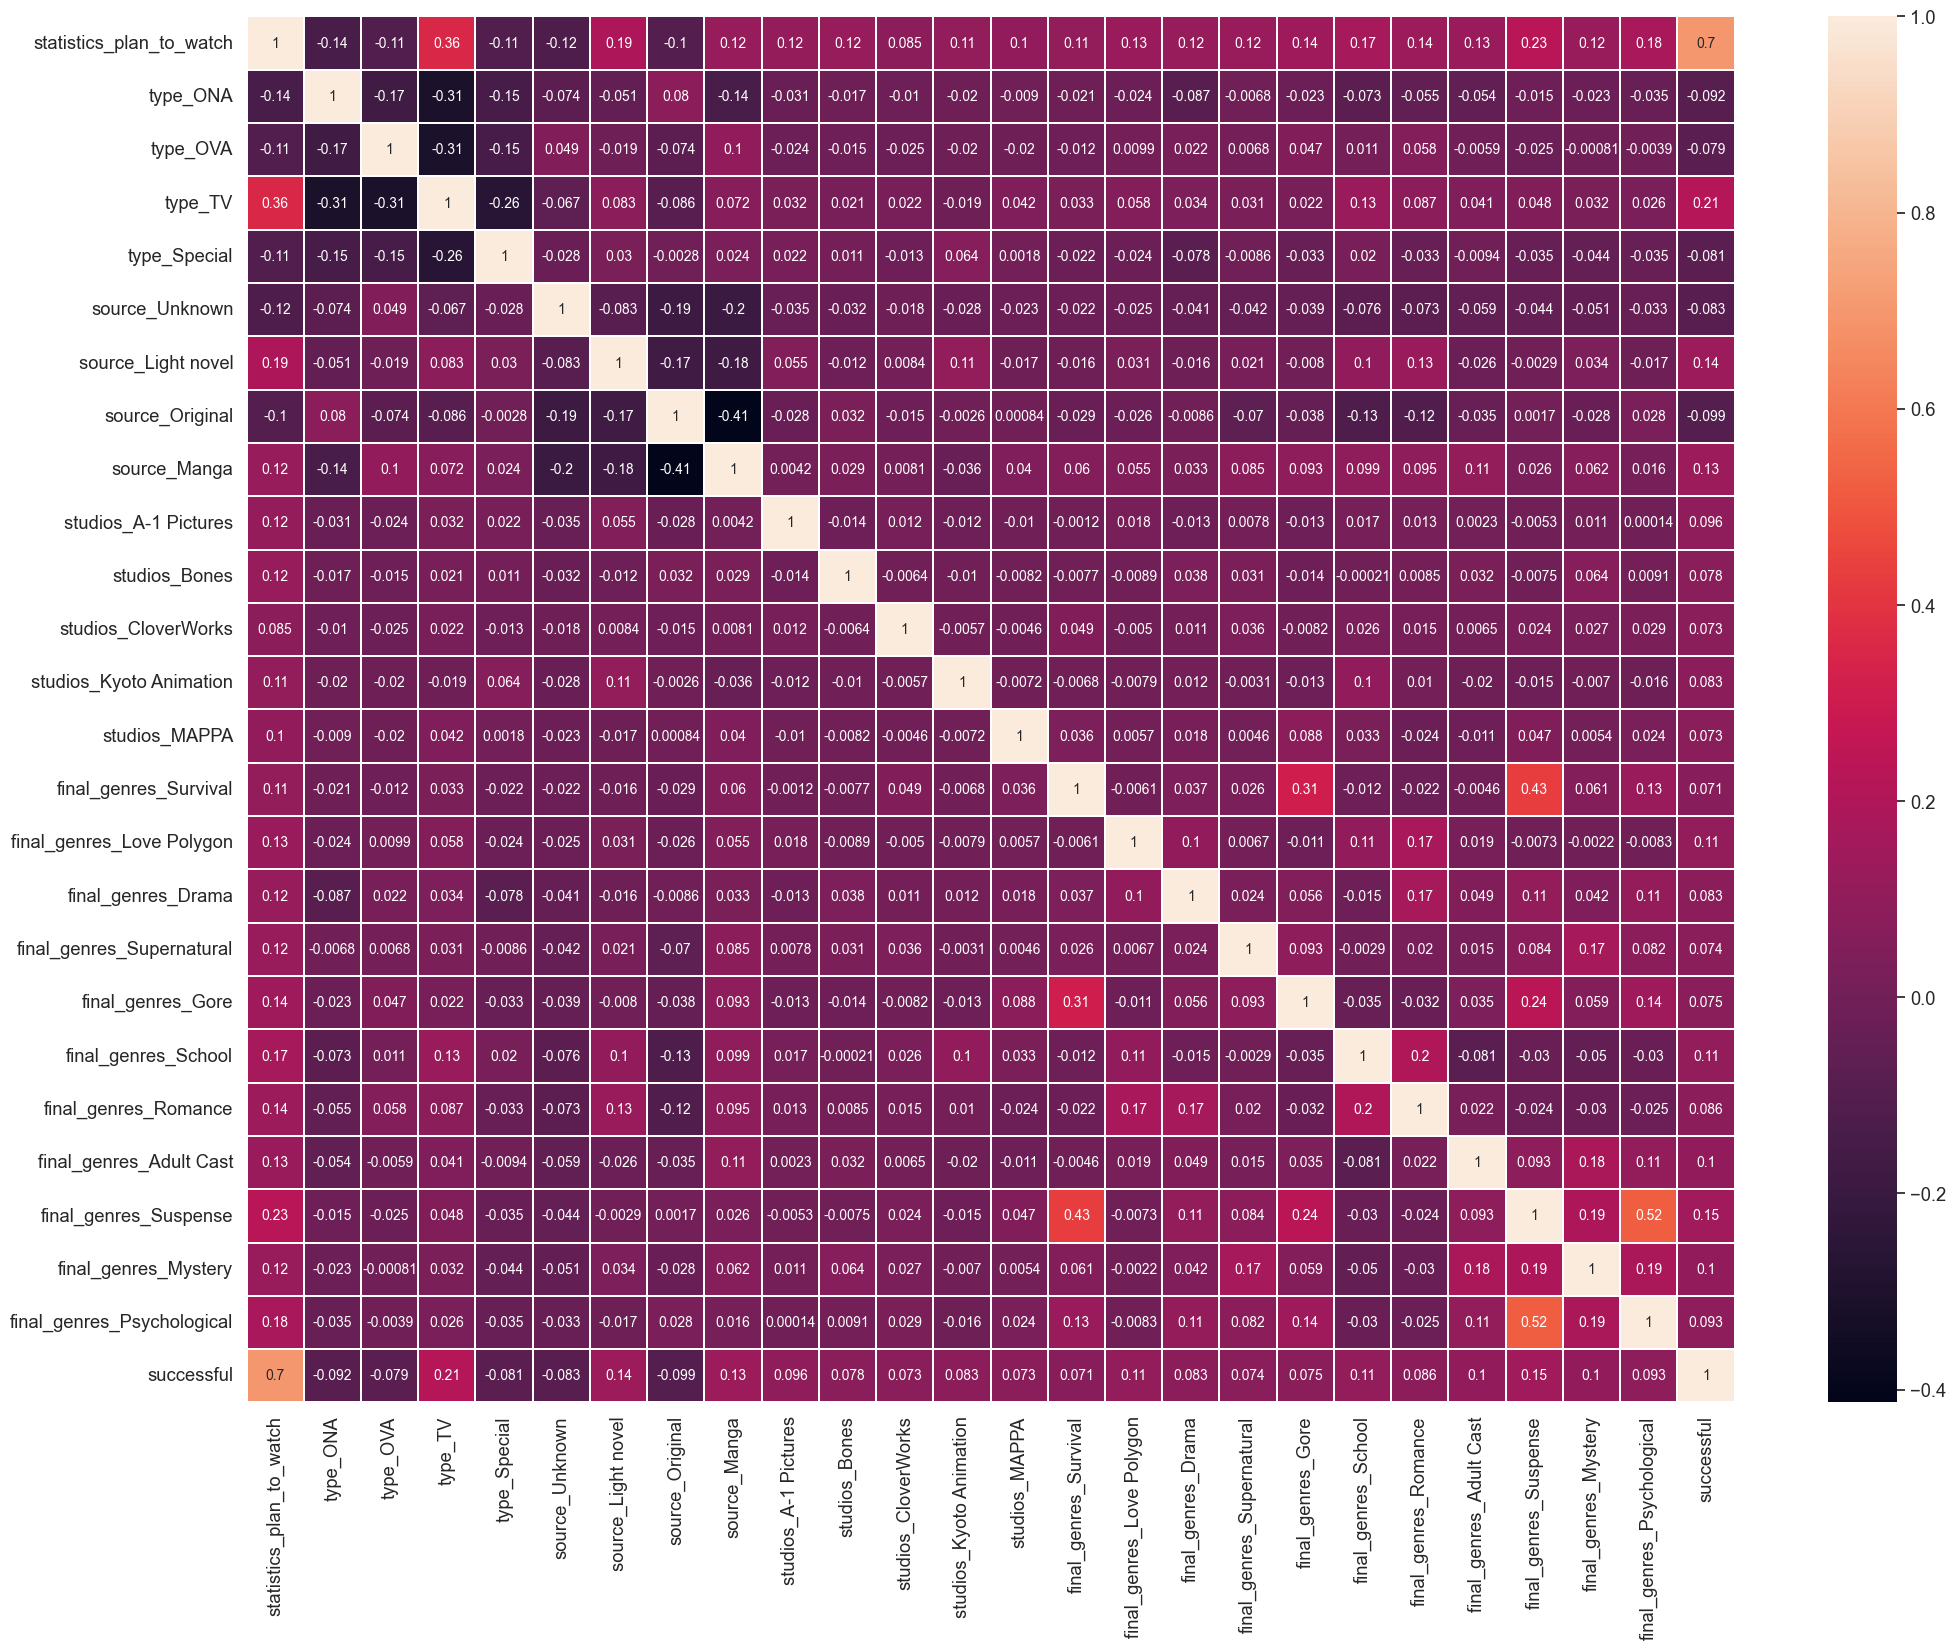

In [163]:
#set the variables
anime_new["successful"] = anime_final["successful"]

# Heat Map
plt.figure(figsize=(24,18))

sb.heatmap(anime_new.corr(), linewidths=.1, annot=True, annot_kws={'size': 10})

plt.show()

# **Modeling**

## 1. Imbalanced Dataset

We can see that we are working on a imbalanced dataset, a dataset that has an imbalanced distribution of the examples of different classes.

#### **Why is Imbalanced Dataset Bad?**
1. Model Bias: Since most machine learning algorithms assume that is balanced across all clasess. Hence, the model thend to be biased towards the majority class, often at the expense of the minority class performance. This mean the model might perform well on the majority class but poorly on the minority class,, which cold be the more critical one to idneitfy correctly.
2. Misleading Accuracy: In the context of imbalance dataset, the common metrics like accuracy can be misleading. For instance, if99% of the data belong to one class, a model that always predicts this majority class will have 99% accuract rate, even thouh it fails to correctly predict the minority class.
3. Because there are fewer instances of the minority class, the model may not have enough information to learn the underlying patterns of that class, leading to poor generalization performance when predicting new data.

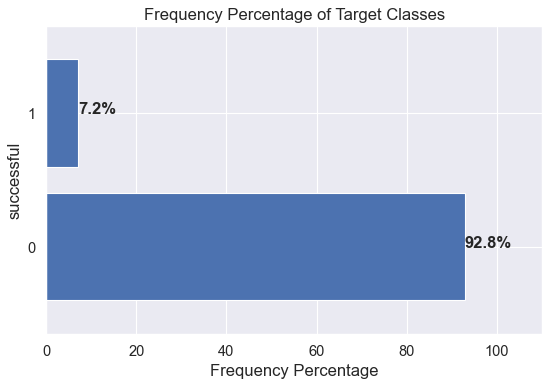

In [164]:
#plot to see the distribution of the target classes
plt.figure(dpi=80)

# Plot frequency percentages barplot
anime_new['successful'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = anime_new['successful'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('successful', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

### 1.1 Techniques to Handle Imbalance Dataset

#### Train Test Split - Imbalanced Dataset

During train test split for a imbalanced dataset, I will be using **stratification**. In the context of train_test_split, stratified sampling can be useful when dealing with imbalanced datasets to ensure that the training and test dataset have the same proportion of class labels as the input dataset. It important, as it aims to ensure that the model is trained and evaluate fairly. 

In [165]:
#Feature and target
dummy_anime = anime_new.copy()

y = pd.DataFrame(dummy_anime['successful']).squeeze() #converts df to series
X = pd.DataFrame(dummy_anime.drop(['successful'], axis=1))


print(X.shape)
print(y.shape)

# Split the Dataset into Train and Test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

(12966, 25)
(12966,)


see the distribution after usig stratification

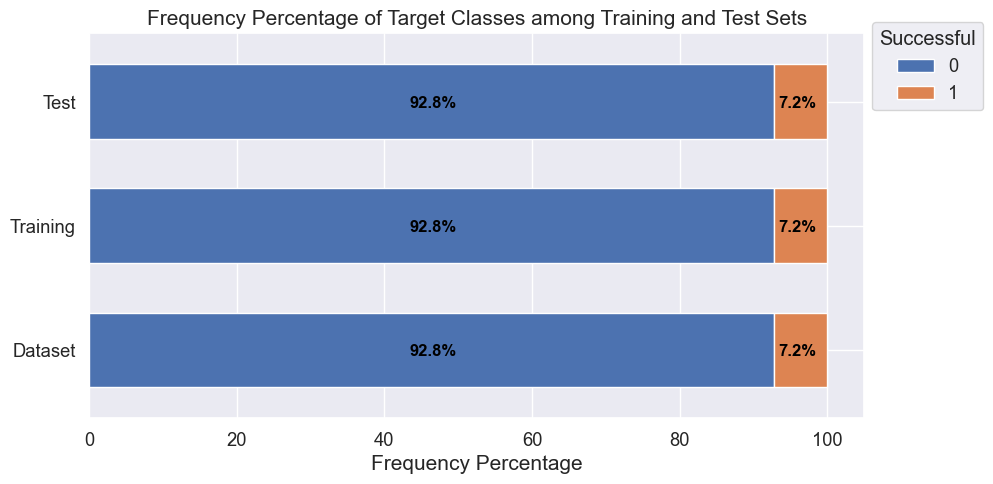

In [166]:
df_percent = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_percent.columns=['Dataset','Training','Test']
df_percent = df_percent.T

# Plot frequency percentages barplot
df_percent.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Add the percentages to our plot
for idx, val in enumerate([*df_percent.index.values]):
    for (percentage, y_location) in zip(df_percent.loc[val], df_percent.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Successful', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()            


### 1.2 Model Evaluation For Imbalanced Dataset

The usual accuracy along can be misleading since high accuracy might just reflect he underlying class distribution rather than the model's ability to discriminate between classes. So here some other way we can use to evaluate the model instead:

1. Precision, Recall and F1-score: 
- **Precision** is a measure of the proportion of anime identified by the model as successful that are indeed successful. A high precision score means that the model has a low number of false positives, which is beneficial for this project because it ensures that the model is not incorrectly labeling many unsuccessful anime as successful. This helps in efficiently allocating resources and focus toward truly promising anime projects.

- **Recall** is a measure of the proportion of actual successful anime that were correctly identified by th emodel. A high recall score means that the model has a low number of false negatives, which is crucial in this project because it ensures that the model is not missing many potential successful anime. This is particularly important because identifying successful anime could be valuable for makign decisions related to marketing, investments, or further content development.

- **F1-score** is a measure of the trade-off between recall and precision. It is calculated as the harmonic mean of recall and precision. A high F1-score is particularly valuable in this project because it indicates a balance between accurately identifying successful anime (high recall) and ensuring that the identified anime are genuinely successful (high precision). This balance is crucial when resources for production, promotion, or further development are limited and must be allocated to actual high-potential anime.


2. AUC Curve:
- So when predicting whether an anime will be successful, AUC can help in assessing how well my model can distinguish between successful and unsuccessful anime across all levels of threshold. A high AUC would mean my model is doigng a good job. 


In Conclusion, all this metrics are important in helping me to evaluate the performance of my model



### 1.2.1 Evaluation Metric Function

In [167]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

### 1.1.3 Model Evaluation Function

### Function Consist of:

#### 1. Confusion Matrix:
When assessing a classification model’s performance, a confusion matrix is essential. It offers a thorough analysis of true positive, true negative, false positive, and false negative predictions, facilitating a more profound comprehension of a model’s recall, accuracy, precision, and overall effectiveness in class distinction. When there is an uneven class distribution in a dataset, this matrix is especially helpful in evaluating a model’s performance beyond basic accuracy metrics
- **True positives (TP):** occur when the model accurately predicts a positive data point.
- **True negatives (TN):** occur when the model accurately predicts a negative data point.
- **False positives (FP):** occur when the model predicts a positive data point incorrectly.
- **False negatives (FN):** occur when the model mispredicts a negative data point.

#### 2. Classification Report:
- **Precision** quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 Score:** The F1 score or F-measure is described as the harmonic mean of the precision and recall of a classification model.

#### 3. ROC AUC Curve:
The **ROC curve** and **AUC metric** are crucial tools in evaluating the performance of binary classification models. The ROC curve plots the true positive rate against the false positive rate at various threshold settings, providing insights into the trade-offs between sensitivity and specificity. The AUC summarizes this performance into a single scalar value, where a higher AUC indicates better model effectiveness in distinguishing between the classes. These tools are particularly valuable in scenarios with imbalanced datasets or when comparing different models, helping to select an optimal threshold that balances various predictive accuracy aspects effectively.

In [168]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sb.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(1, 2)
    table.set_fontsize(20)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

### 1.1.4 Handling Imbalanced dataset

#### 1.1.4.1 Resampling Data Approaches:

- **Random Oversampling:**
Random ovesampling addresses imbalance in datasets, by reducing the size of the majority class, it increase the size of minorty class by creaing a more balanced dataset.
    - **Con:** There is risk of overfitting as the model might learn the exact replicas too well, failing to generalise to new, unseen data.


- **Random Undersampling:**
Random undersampling is a technique used to handle imbalanced datasets, and address it by reducing the size of te majority class to balance the class distribution.
    - **Con:** 
    Although it can help improve model performance on the minority class, but there is drawbacks such as **loss of information**, by removing instances from the majority class, potentially valuable information can be lost , which might be imprtant for building a robust

- **SMOTE:**
SMOTE which stands for Synthetic Minority Over-sampling Technique, is a widely used method for handling imbalanced dataset. Unlike simple random oversampling, SMOTE generates synthetic examples rather than duplicating existing ones.
    - **Con:** It may introduce synthetic samples that are unrealistic or noisy, leading to overfitting or reduced generalisation performance.
    

- **But Avoid These!!!!:**
    - When using sampling techniques, we will divide the data first and then apply synthetic sampling on the **training data only**. After doing the training, we will then use the test set (which contains only original samples) to evaluate. 
    - The test set should not be preprocessed with the training data. This will ensure no 'peeking ahead'. Train data should be preprocessed separately and once the model is created we can apply the same preprocessing parametes used for the train set, onto the test set as though the test set didn't exist before



#### 1.1.4.2 Model-Based Approaches:
1. **Tree-based algorithms** often perform well on imbalanced datasets.
2. **Boosting algorithms** ( e.g AdaBoost, XGBoost,…) are ideal for imbalanced datasets because higher weight is given to the minority class at each successive iteration. during each interation in training the weights of misclassified classes are adjusted.




**Conclusion:** 
Looking at the cons that the resampling technqiues brought us, we be tackling from the model-based approach instead

## 2. Model Comparison

### 1. Baseline Model - DummyClassifier 

These is used to create simple baseline models for comparison with more advanced models. 

We be using "stratified": this strategy randomly selects class labels based on he class distribution in the training set. It aims to maintain the same class distribution as the training data, makign it useful for imbalanced classes. 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      9629
           1       0.07      0.07      0.07       743

    accuracy                           0.87     10372
   macro avg       0.50      0.50      0.50     10372
weighted avg       0.87      0.87      0.87     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2408
           1       0.06      0.06      0.06       186

    accuracy                           0.86      2594
   macro avg       0.50      0.50      0.50      2594
weighted avg       0.87      0.86      0.86      2594



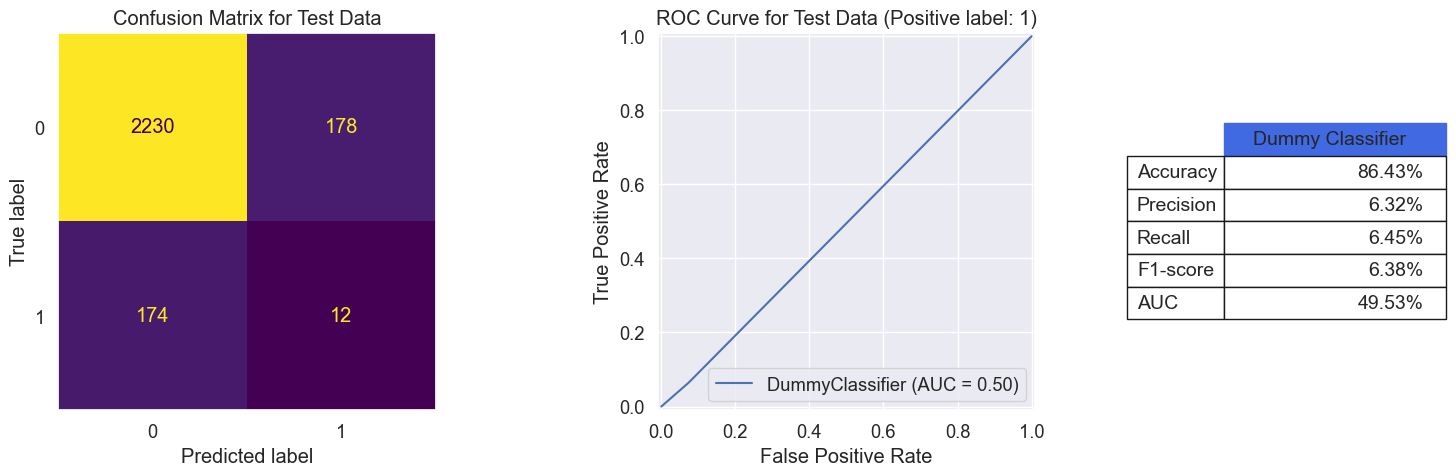

In [169]:
# Create a baseline random classifier
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Fit the baseline classifier on the training data
dummy_clf.fit(x_train, y_train)

model_evaluation(dummy_clf, x_train, x_test, y_train, y_test, 'Dummy Classifier  ')

#save the result for comparison later
dummy_result = metrics_calculator(dummy_clf, x_test, y_test, 'Baseline Model')

### 2. Logistic Regression




	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9629
           1       0.91      0.50      0.64       743

    accuracy                           0.96     10372
   macro avg       0.93      0.75      0.81     10372
weighted avg       0.96      0.96      0.96     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2408
           1       0.86      0.51      0.64       186

    accuracy                           0.96      2594
   macro avg       0.91      0.75      0.81      2594
weighted avg       0.96      0.96      0.95      2594



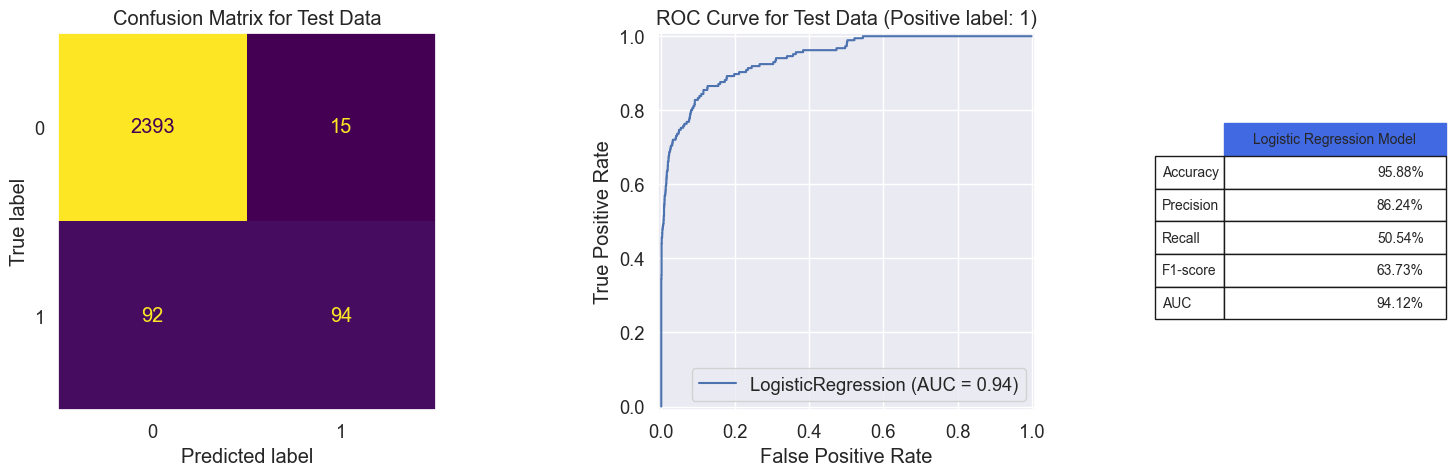

In [170]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)
model_evaluation(model_lr, x_train, x_test, y_train, y_test, 'Logistic Regression Model')

#save the result for comaparison later
lr_result = metrics_calculator(model_lr, x_test, y_test, 'Logistic Regression')

### 3. Decision Tree


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9629
           1       1.00      1.00      1.00       743

    accuracy                           1.00     10372
   macro avg       1.00      1.00      1.00     10372
weighted avg       1.00      1.00      1.00     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2408
           1       0.55      0.63      0.59       186

    accuracy                           0.94      2594
   macro avg       0.76      0.79      0.78      2594
weighted avg       0.94      0.94      0.94      2594



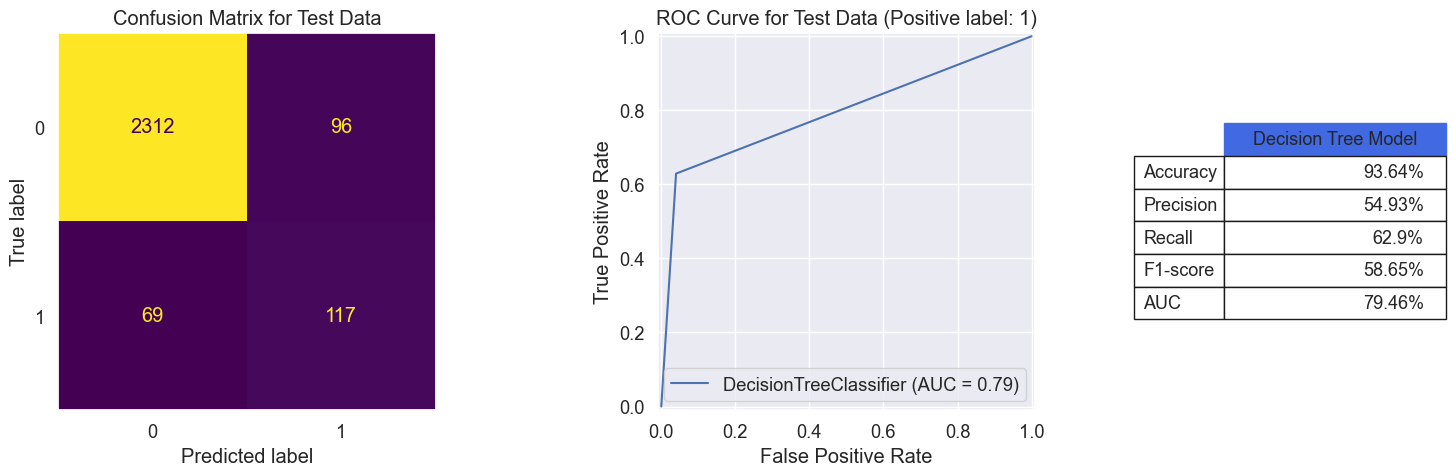

In [171]:
model_dt = DecisionTreeClassifier(random_state=0)
model_dt.fit(x_train, y_train)
model_evaluation(model_dt, x_train, x_test, y_train, y_test, 'Decision Tree Model')

#save the result for comaparison later
# dt_result = metrics_calculator(model_dt, x_test, y_test, 'Decision Tree')

### 4. ADA Boosting

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9629
           1       1.00      1.00      1.00       743

    accuracy                           1.00     10372
   macro avg       1.00      1.00      1.00     10372
weighted avg       1.00      1.00      1.00     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2408
           1       0.55      0.64      0.59       186

    accuracy                           0.94      2594
   macro avg       0.76      0.80      0.78      2594
weighted avg       0.94      0.94      0.94      2594



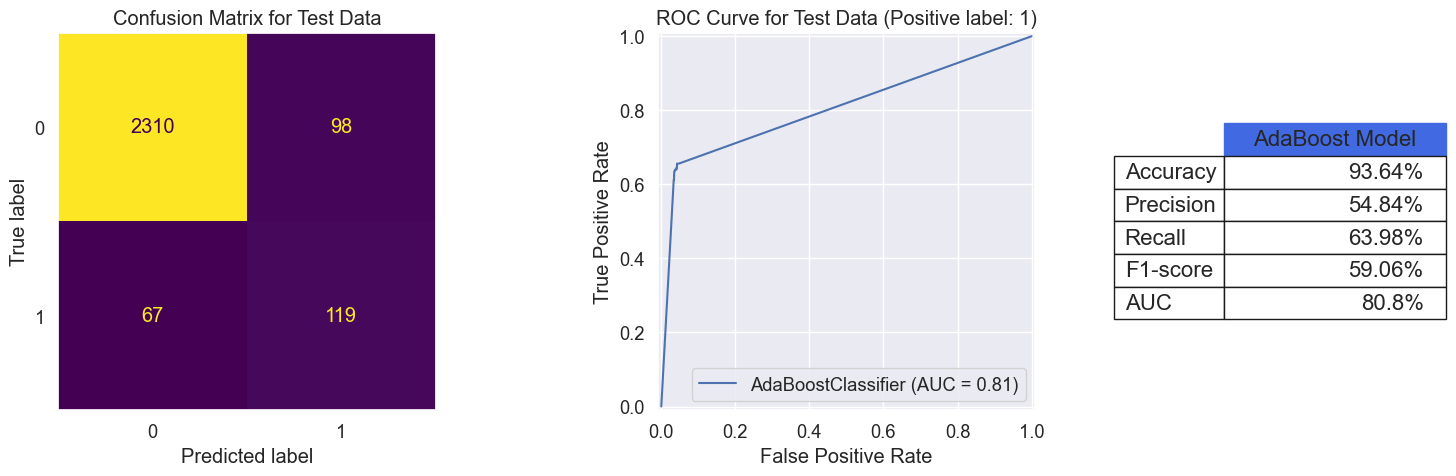

In [172]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier(DecisionTreeClassifier())

# Train the final AdaBoost classifier
model_ada.fit(x_train, y_train)

model_evaluation(model_ada, x_train, x_test, y_train, y_test, 'AdaBoost Model')

#save the result for comaparison later
ada_result = metrics_calculator(model_ada, x_test, y_test, 'AdaBoost')

### 5. Random Forest


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9629
           1       1.00      1.00      1.00       743

    accuracy                           1.00     10372
   macro avg       1.00      1.00      1.00     10372
weighted avg       1.00      1.00      1.00     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2408
           1       0.69      0.63      0.66       186

    accuracy                           0.95      2594
   macro avg       0.83      0.80      0.82      2594
weighted avg       0.95      0.95      0.95      2594



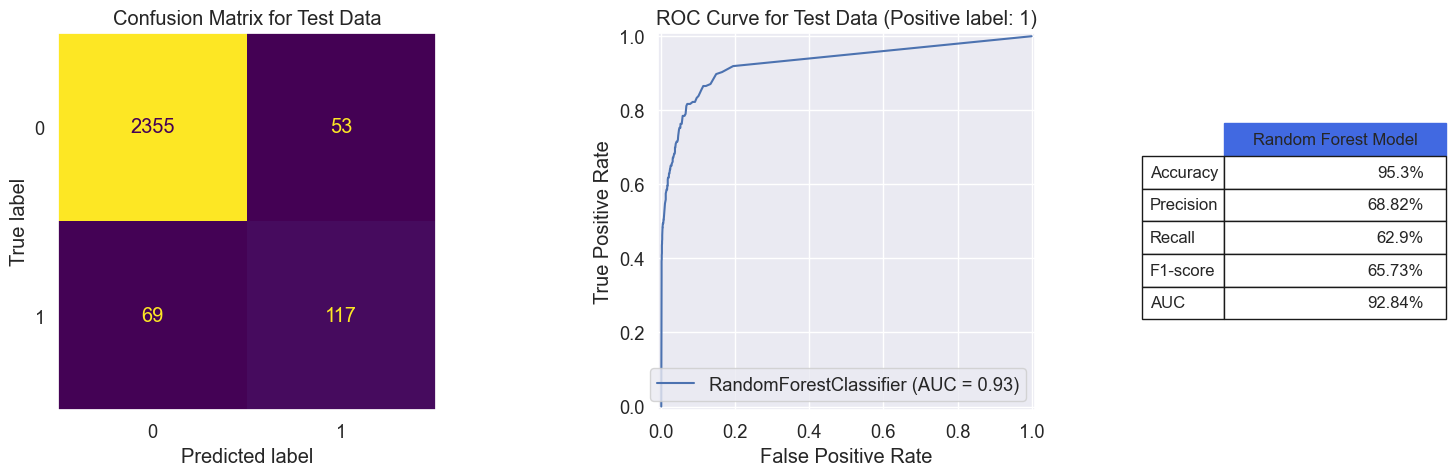

In [173]:
model_rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)
model_rf.fit(x_train, y_train)
model_evaluation(model_rf, x_train, x_test, y_train, y_test, 'Random Forest Model')

#save the result for comaparison later
rf_result = metrics_calculator(model_rf, x_test, y_test, 'Random forest')

### 6. KNN


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9629
           1       0.83      0.58      0.68       743

    accuracy                           0.96     10372
   macro avg       0.90      0.78      0.83     10372
weighted avg       0.96      0.96      0.96     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2408
           1       0.64      0.44      0.52       186

    accuracy                           0.94      2594
   macro avg       0.80      0.71      0.74      2594
weighted avg       0.93      0.94      0.94      2594



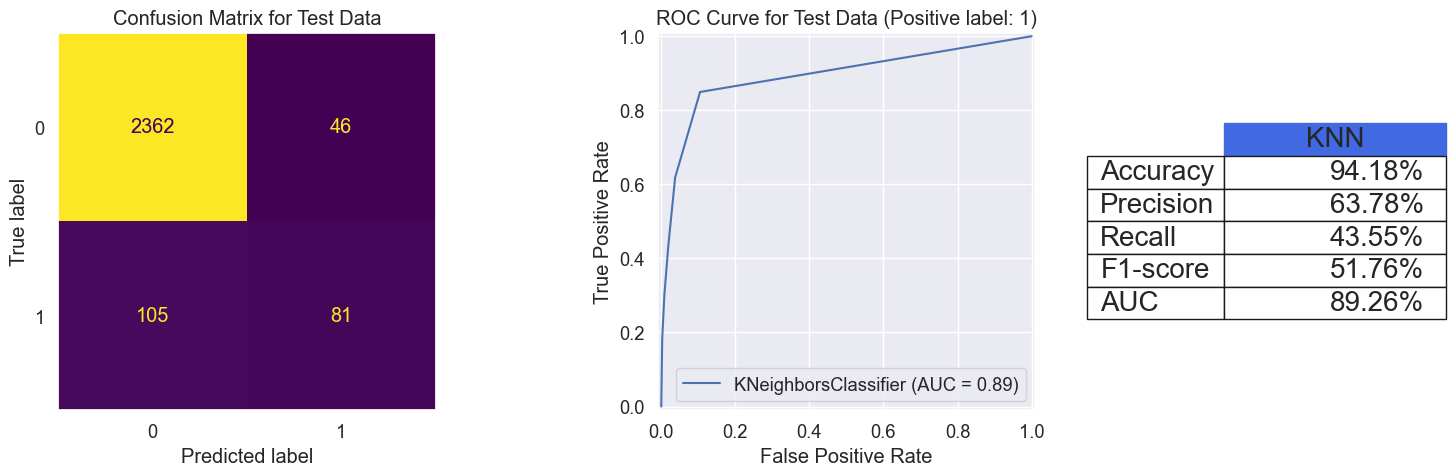

In [174]:
model_knn = KNeighborsClassifier()
model_knn.fit(x_train, y_train)
model_evaluation(model_knn, x_train, x_test, y_train, y_test, 'KNN')

#save the result for comaparison later
knn_result = metrics_calculator(model_knn, x_test, y_test, 'KNN')

### 6. Gradient Boosting


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9629
           1       0.87      0.65      0.74       743

    accuracy                           0.97     10372
   macro avg       0.92      0.82      0.86     10372
weighted avg       0.97      0.97      0.97     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2408
           1       0.80      0.65      0.71       186

    accuracy                           0.96      2594
   macro avg       0.89      0.82      0.85      2594
weighted avg       0.96      0.96      0.96      2594



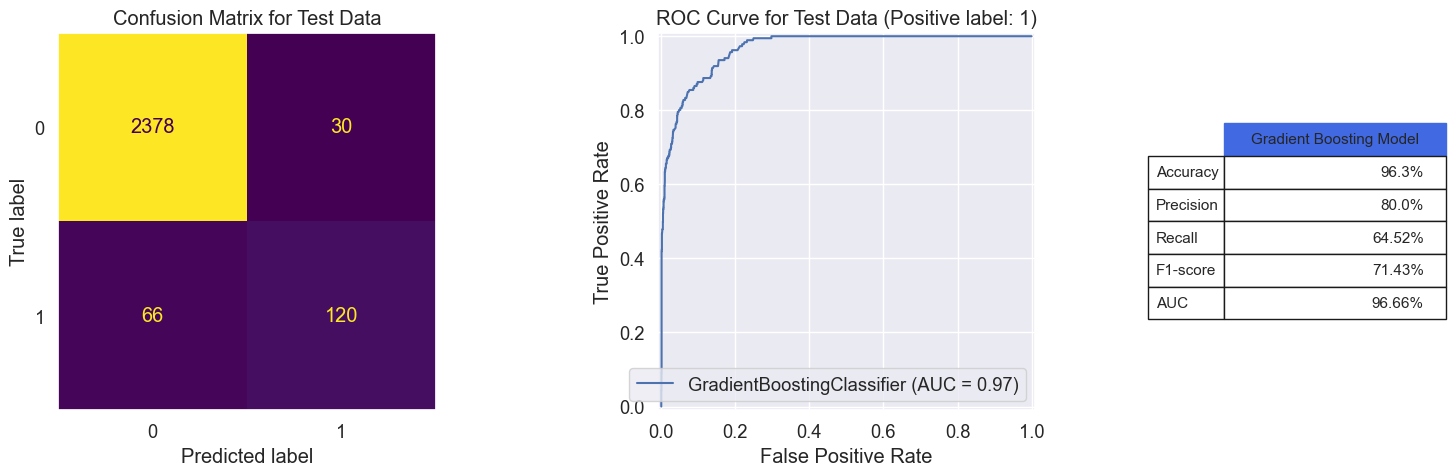

In [175]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(max_features=None, criterion='friedman_mse', random_state=0)


# Train the XGBoost Classifier
model_gb.fit(x_train, y_train)
model_evaluation(model_gb, x_train, x_test, y_train, y_test, 'Gradient Boosting Model')

#save the result for comaparison later
gb_result = metrics_calculator(model_gb, x_test, y_test, 'Gradient Booosting')


### 7. XGBoosting


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9629
           1       0.90      0.73      0.81       743

    accuracy                           0.98     10372
   macro avg       0.94      0.86      0.90     10372
weighted avg       0.97      0.98      0.97     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2408
           1       0.77      0.62      0.69       186

    accuracy                           0.96      2594
   macro avg       0.87      0.80      0.83      2594
weighted avg       0.96      0.96      0.96      2594



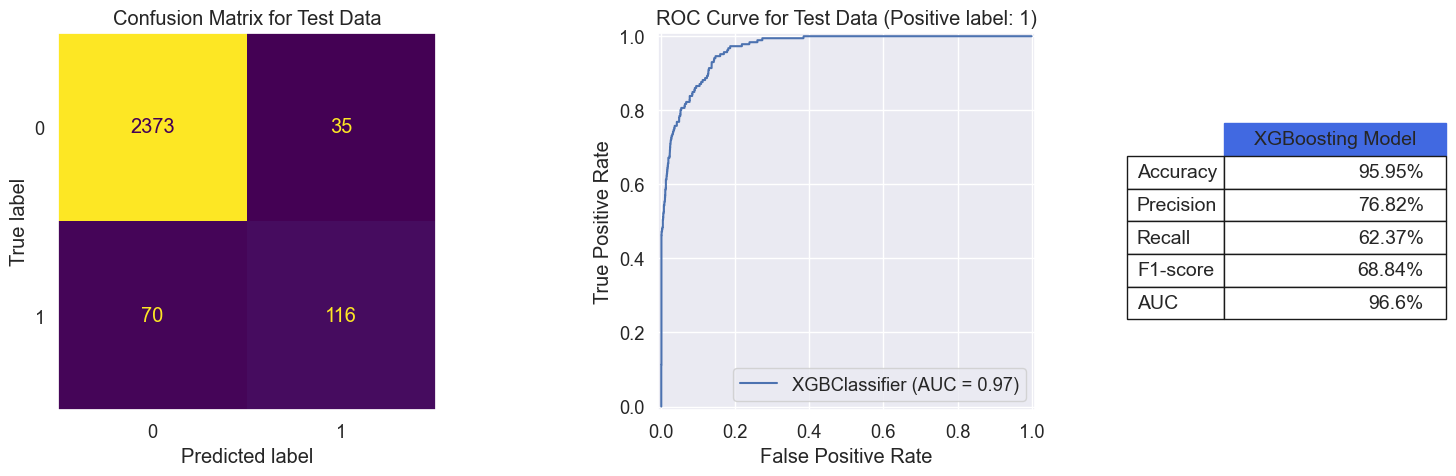

In [176]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()


# Train the XGBoost Classifier
model_xgb.fit(x_train, y_train)
model_evaluation(model_xgb, x_train, x_test, y_train, y_test, 'XGBoosting Model')

#save the result for comaparison later
xgb_result = metrics_calculator(model_xgb, x_test, y_test, 'XGBoost')


### 8. Extra Trees


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9629
           1       1.00      1.00      1.00       743

    accuracy                           1.00     10372
   macro avg       1.00      1.00      1.00     10372
weighted avg       1.00      1.00      1.00     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2408
           1       0.68      0.64      0.66       186

    accuracy                           0.95      2594
   macro avg       0.82      0.81      0.82      2594
weighted avg       0.95      0.95      0.95      2594



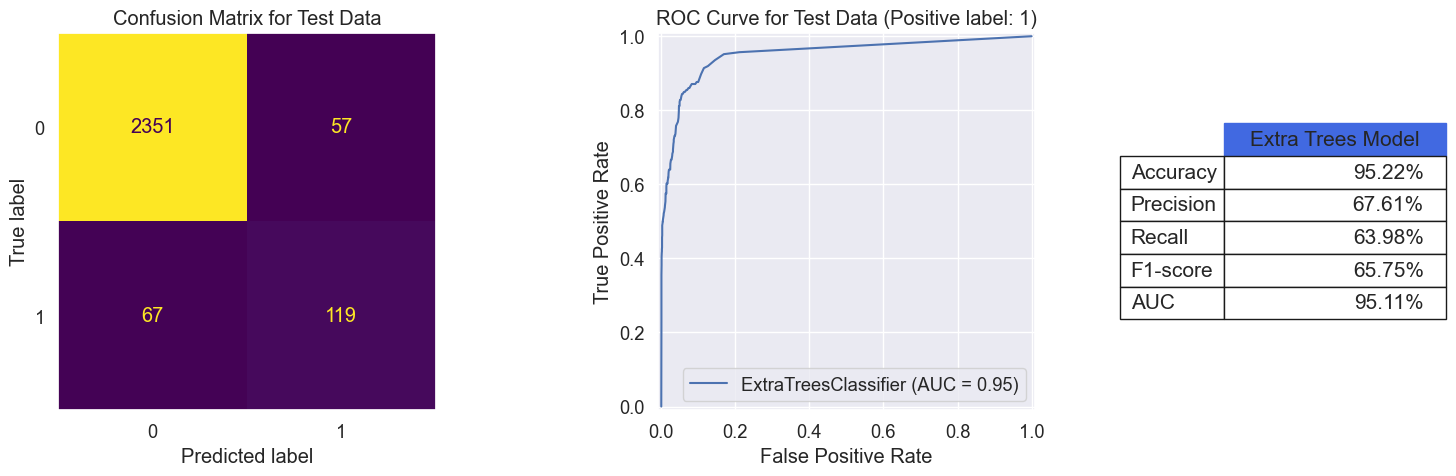

In [183]:
# Create a random forest classifier object
model_et = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

model_et.fit(x_train, y_train)

model_evaluation(model_et, x_train, x_test, y_train, y_test, 'Extra Trees Model')

#save the result for comaparison later
et_result = metrics_calculator(model_et, x_test, y_test, 'Extra Tree')

### Final Model Comparison Table

In [184]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([lr_result, ada_result, knn_result,
           rf_result, xgb_result, gb_result, dummy_result, et_result], axis=1).T

# Sort the dataframe in descending order based on F1-score values
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

,Accuracy,Precision,Recall,F1-score,AUC
Gradient Booosting,96.3%,80.0%,64.52%,71.43%,96.66%
XGBoost,95.95%,76.82%,62.37%,68.84%,96.6%
Extra Tree,95.22%,67.61%,63.98%,65.75%,95.11%
Random forest,95.3%,68.82%,62.9%,65.73%,92.84%
Logistic Regression,95.88%,86.24%,50.54%,63.73%,94.12%
Baseline Model,86.43%,6.32%,6.45%,6.38%,49.53%
AdaBoost,93.64%,54.84%,63.98%,59.06%,80.8%
KNN,94.18%,63.78%,43.55%,51.76%,89.26%


**Conclusion:** 

We will be gauging the performance of our model by using F1-score instead of the accuracy as our data is imbalance and the accuracy will be incorrect since the accuracy might that the model was able to accurately predict the majority class but not the minority class, therefore the F1-score willbe a better gauge in this case. 

By comparing the F1-score for all the model, as we can see Gradient Boosting, XGBoost and Extra Tree models perform the best out of all the other models. But I will choose XGBoost and Extra Tree to tune instead, as mentioned aboved this algorithms works better with imbalanced dataset


## 3. Hyperparameter Tuning

### Function For Hyperparameter Tuning

In [100]:
# metric for evaluating our model
def f1_score_metric(model, X_train, y_train):
    '''
    This function reports f1-score metric for the class specified by 'Positive Label' (or '1')
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

In [101]:
from sklearn.model_selection import StratifiedKFold
def hyperparameter_tune(clf, param_grid, X_train, y_train):
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=f1_score_metric, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model 
    return clf_grid.best_estimator_

### 3.1 XGBoost

- **max_depth:** Maximum depth of a tree. increasing this value will make the model more complex and likely more overfit.
- **eta(learning_rate):** step size shrinkage used to prevent overfitting. Range is from 0-1
- **n_estimators:** Number of trees in forest
- **min_child_weight:** Minimum sum of instance weight (hessian) needed in a child. used to control over-fitting
- **scale_pos_weight:** It is the ratio of number of negative class to the positive class and controls the balance of positive and negative weights, useful for unbalanced classes.
- **subsample:** Fraction of the raining data to be randomly sampled for each tree
- **solsample_bytree:** Fraction of features used per tree
- **solsample_bylevel:** Fraction of features used per level
- **reg_alpha:** L1 regularization term on weights
- **reg_lambda:** L2 regularization term on weights 
- **max_delta_step:** Maximum delta step allowed for each tree's weight estimation to be.
- **gamma:** it the minuimum loss reduction required to make further partition on a leaf node of the tree


#### Hyperparameters for XGBoost

In summary, while all parameters can influence the outcome and should be tuned in conjunction with one another, scale_pos_weight is typically the starting point for addressing class imbalance directly. Following that, min_child_weight, gamma, and subsampling parameters can have the next most significant effects on the model's performance with imbalanced data. It is often recommended to use a combination of these parameter adjustments with cross-validation to determine their optimal values for your specific dataset.

In [105]:
# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Define the hyperparameter grid to search

xgb_params = {
    'max_depth': [3, 4, 6], # Shallower trees to prevent overfitting.
    'n_estimators': [100, 200, 300], # More trees can give more chances to learn from the minority class.
    'min_child_weight': [1, 3, 5], # Higher values to prevent overfitting to the minority class.
    'scale_pos_weight': [ratio, ratio*1.5, ratio*2], # Adjusting the scale of the positive weight to focus more on the minority class.
    'subsample': [0.7, 0.8, 0.9], # Slightly less than 1 to introduce more randomness and prevent overfitting.
    'colsample_bytree': [0.7, 0.8, 0.9], # Slightly less than 1 to add randomness and prevent overfitting.
    'gamma': [0.1, 0.3, 0.5], # Non-zero gamma to prevent overfitting to the minority class.
    'learning_rate': [0.01, 0.1, 0.2], # Lower learning rates as more conservative updates can be beneficial for imbalanced data.
}

In [106]:
#tune the model to get the best parameters
xgb_model_tune = hyperparameter_tune(model_xgb, xgb_params, x_train, y_train)

Best hyperparameters:
 {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'scale_pos_weight': 12.959623149394348, 'subsample': 0.9}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      9629
           1       0.74      1.00      0.85       743

    accuracy                           0.97     10372
   macro avg       0.87      0.99      0.92     10372
weighted avg       0.98      0.97      0.98     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2408
           1       0.54      0.74      0.63       186

    accuracy                           0.94      2594
   macro avg       0.76      0.84      0.80      2594
weighted avg       0.95      0.94      0.94      2594



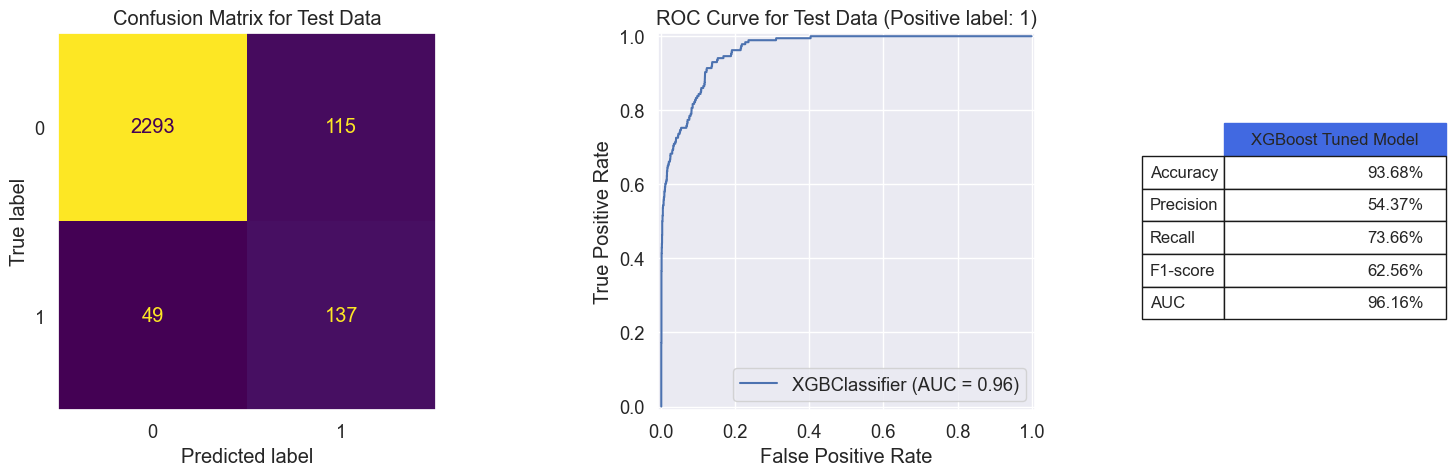

In [181]:
#evaluate the model
model_evaluation(xgb_model_tune, x_train, x_test, y_train, y_test, 'XGBoost Tuned Model')

#save the result for comaparison later
xgb_tune_result = metrics_calculator(xgb_model_tune, x_test, y_test, 'XGBoost Tuned')

## 3.2 Extra Trees

#### Hyperparameters Tuning Features:

- **n_estimators:** The number of trees in the forest, higher values generally improve the model but also increase computational cost.
- **max_depth:** The max depth of the tress. Settign a limit ca help prevent overfitting.
- **min_samples_split:** The minimum number of samples required to split an internal node.
- **min_samples_leaf:** The minimum number of samples requireed to be at a leaf node.
- **class_weight:** It particularly important for handling datasets where classes are imbalanced. 


In [185]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 150], 
    'max_depth': [10,12,14],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'class_weight': class_weights
}

# Create a random forest classifier object
et = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
et_opt = hyperparameter_tune(et, param_grid, x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
2700 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python

Best hyperparameters:
 {'class_weight': {0: 0.3164736842105263, 1: 0.6835263157894738}, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9629
           1       0.86      0.79      0.82       743

    accuracy                           0.98     10372
   macro avg       0.92      0.89      0.91     10372
weighted avg       0.98      0.98      0.98     10372


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2408
           1       0.72      0.66      0.69       186

    accuracy                           0.96      2594
   macro avg       0.84      0.82      0.83      2594
weighted avg       0.96      0.96      0.96      2594



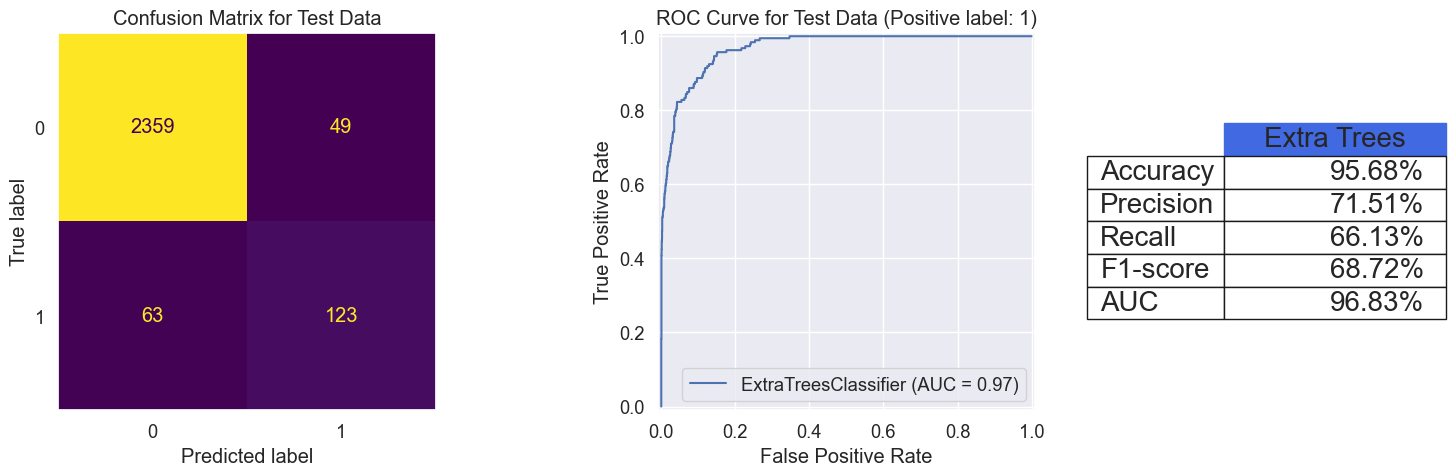

In [186]:
model_evaluation(et_opt, x_train, x_test, y_train, y_test, 'Extra Trees')
et_tune_result = metrics_calculator(et_opt, x_test, y_test, 'Extra Trees Tuned ')

### Tuned Model Comparison

In [187]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([xgb_tune_result, et_tune_result], axis=1).T

# Sort the dataframe in descending order based on F1-score values
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

,Accuracy,Precision,Recall,F1-score,AUC
Extra Trees Tuned,95.68%,71.51%,66.13%,68.72%,96.83%
XGBoost Tuned,93.68%,54.37%,73.66%,62.56%,96.16%


## 3. Feature Importance

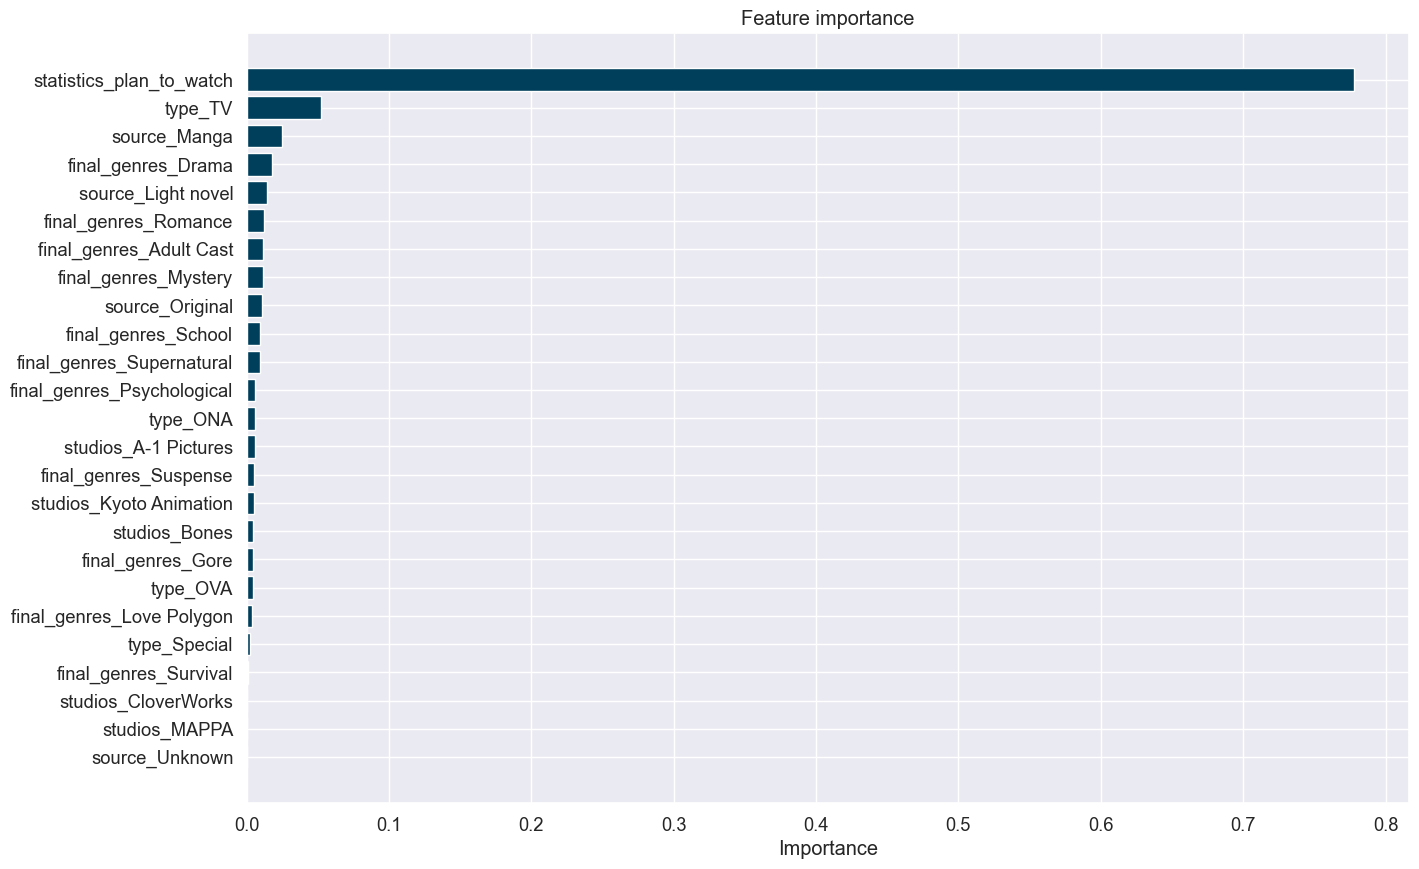

In [188]:
#plot the graph
features_list = anime_new.columns.values
feature_importance = et_opt.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(15,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color =['#003F5C'])
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')

plt.show()

# **Conclusion (What we did)**

### EDA Insights:
- We had idenitified that relying solely on single factors such as rank or popularity can be misleading in determining anime success. This insight led to the development of a more nuanced target variable that considers multiple factors (rank, popularity, and score).

<br>

### Target Variable Definition:
- A multi-faceted approach to define success was adopted, incorporating top rankings, popularity, and a high score as indicators of a successful anime. This approach aims to capture a broader spectrum of what makes an anime successful, beyond superficial metrics.
- Successful (1): Top 600 in Rank or Top 600 in Popularity or Score >= 8.5

<br>

### Data Preprocessing and Feature Engineering:
- We handled categorical data using one-hot encoding to prepare it for machine learning algorithms, ensuring that the models could effectively interpret these variables.
- Feature scaling was applied to ensure that numerical data does not dominate the model's learning process, providing a level playing field for all features.
- We then proceed to use selectKbest to do feature selections to get the top 25 most importance features, and drop those that is less of importance

<br>


### Handling Imbalanced Data:
- The dataset was identified as imbalanced. We discussed strategies like Random Oversampling, SMOTE, and model-based approaches to handle this, ultimately choosing to proceed with model-based strategies to mitigate the potential cons associated with resampling methods.

<br>


### Model Selection and Evaluation:
- A range of models was evaluated, including logistic regression, decision trees, ensemble methods, and boosting algorithms. Each model's performance was assessed using metrics suitable for imbalanced data, such as the F1-score, to ensure that both the majority and minority classes were being predicted accurately.

<br>


### Hyperparameter Tuning:
- We also performed hyperparameter tuning for models like XGBoost and Extra Trees, focusing on parameters that influence model complexity and the handling of imbalanced data. This step is crucial to optimize the models for best performance.

<br>


### Feature Importance Analysis:
- After training, you evaluated the feature importance which helps in understanding which features most significantly influence the prediction of an anime's success. This insight is valuable for further refining the models and potentially reducing model complexity by eliminating less important features. We can see from the graph that the most important features were statistic_plan_to_watch, type_tv, source_manga, final_genres_drama and source_Light Novel.

<br>


### Final Model Selection:
- The performance of all models was compared, and the best-performing models were identified based on the F1-score. This step ensures that the chosen model provides a balanced approach to classifying successful and unsuccessful anime. Which our final model is **Extra Tree Model**, which is also know to be good for working with imbalanced dataset

<br>


### Strategic Recommendations:
- The models and their insights can guide stakeholders in making informed decisions about anime production, marketing strategies, and further content development. This data-driven approach can significantly enhance the effectiveness of resource allocation and strategic planning in the anime industry.

<br>


### Key Takeaways:
- Multi-dimensional Success Metrics: Combining various indicators to define success provides a more accurate and realistic measure of an anime's performance.
- Importance of Handling Imbalance: Properly addressing data imbalance ensures that the model's performance is genuine and not skewed towards the majority class.
- Role of Feature Engineering: Effective feature engineering enhances model performance and ensures that predictive modeling processes are based on relevant and impactful data.

<br>


### Future Possibility:
- Although the f1-score, precision, and recall was not that good but in the future, with time and cost allowed, we can actually increase the amount of hyperparameter tuning, to increase the parameters for tuning, for the model to be train even more rigourously to find a better combination of parameters, to improve our model performance. Also, we can make use of the feature importance anaslysis that we got from training the model, and removed those less important feature to help in reducing the model complexity even further, or try out other more advanced methods to help in fixing our imabalnced dataset problem. 

### **In conclusion:**
The Anime Classification Project, encompassing both extensive exploratory data analysis (EDA) and the development of predictive classification models, provides a comprehensive toolkit for stakeholders in the anime industry. This project's findings and methodologies offer valuable insights and actionable intelligence that can guide investment and production decisions, helping to maximize the success and appeal of anime content in an increasingly competitive market.